In [13]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from numpy import concatenate
from math import sqrt
import pandas as pd
import numpy as np

In [14]:
xlsx_file = pd.ExcelFile('./2021-2022_O3&气象五参.xlsx')
sheet_names = xlsx_file.sheet_names
data = pd.DataFrame()

In [15]:
#得到2021和2022年的数据
for sheet in sheet_names[0:2]:
    df = xlsx_file.parse(sheet)
    data = pd.concat([data,df])

In [16]:
data['C1705_DATETIME'] = pd.to_datetime(data['C1705_DATETIME'])
data_values = data[data['C0007_PNAME']=='八大关街道']

In [17]:
data_values['O3VAL'] = data_values['O3VAL'].interpolate()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_42624\1802229502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_values['O3VAL'] = data_values['O3VAL'].interpolate()


In [18]:
data_values = data_values.values
data_values[0]

array(['八大关街道', Timestamp('2021-01-01 00:00:00'), 6.938, -4.038, 1.38,
       134.779, 50.243, 1029.0], dtype=object)

In [19]:
features = data_values[:,3:]
target = data_values[:,2]   
target = target.astype((float))
target = np.reshape(target,(-1,1))
# 假设我们想将最后20%的数据作为测试集
split_index = int(len(features) * 0.95)

train_X = features[:split_index]
test_X = features[split_index:]

train_y = target[:split_index]
test_y = target[split_index:]

# 由于是LSTM模型，需要对数据进行适当的重塑以适应模型输入
# 假设每个样本为一个时间序列，序列长度固定或已知
timesteps = train_X.shape[1]  # 假定第一个维度是样本数，第二个维度是时间序列的长度

train_X_reshaped = train_X.reshape(train_X.shape[0], timesteps, -1)
test_X_reshaped = test_X.reshape(test_X.shape[0], timesteps, -1)

print("训练集特征形状:", train_X_reshaped.shape)
print("测试集特征形状:", test_X_reshaped.shape)
print("训练集目标形状:", train_y.shape)
print("测试集目标形状:", test_y.shape)

训练集特征形状: (16644, 5, 1)
测试集特征形状: (876, 5, 1)
训练集目标形状: (16644, 1)
测试集目标形状: (876, 1)


In [20]:
train_X_reshaped = train_X_reshaped.astype(np.float64)
test_X_reshaped = test_X_reshaped.astype(np.float64)
train_X_reshaped.dtype

dtype('float64')

730 days 
24 hours preday
train_ratio = 0.8
test_ration = 0.2

In [21]:
'''
features = data_values[:,3:]
target = data_values[:,2]   
target = target.astype((float))
target = np.reshape(target,(-1,1))
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
t_scaler = MinMaxScaler()
scaled_target = t_scaler.fit_transform(target)
train_size = int(len(features)*0.8)
train_X, train_y = scaled_features[:train_size], scaled_target[:train_size,0]
test_X, test_y = scaled_features[train_size:], scaled_target[train_size:,0]

# 将训练数据转换为LSTM的输入格式 (samples, timesteps, features)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
'''

'\nfeatures = data_values[:,3:]\ntarget = data_values[:,2]   \ntarget = target.astype((float))\ntarget = np.reshape(target,(-1,1))\nscaler = MinMaxScaler()\nscaled_features = scaler.fit_transform(features)\nt_scaler = MinMaxScaler()\nscaled_target = t_scaler.fit_transform(target)\ntrain_size = int(len(features)*0.8)\ntrain_X, train_y = scaled_features[:train_size], scaled_target[:train_size,0]\ntest_X, test_y = scaled_features[train_size:], scaled_target[train_size:,0]\n\n# 将训练数据转换为LSTM的输入格式 (samples, timesteps, features)\ntrain_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))\ntest_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))\n'

In [22]:
features

array([[-4.038, 1.38, 134.779, 50.243, 1029.0],
       [-3.888, 1.255, 190.495, 49.828, 1029.0],
       [-4.248, 1.068, 180.058, 51.991, 1029.0],
       ...,
       [3.059, 0.559, 81.128, 75.709, 1030.775],
       [2.428, 0.972, 81.307, 77.054, 1031.0],
       [1.685, 0.878, 170.63, 78.406, 1031.0]], dtype=object)

In [23]:
target

array([[ 6.938],
       [13.344],
       [11.474],
       ...,
       [23.378],
       [ 7.542],
       [ 5.128]])

In [24]:
# 构建LSTM模型
model = Sequential()
model.add(LSTM(units=64, input_shape=(train_X_reshaped.shape[1], train_X_reshaped.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 查看模型结构
model.summary()

d:\miniconda3\envs\IR\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# 训练模型
model.fit(train_X_reshaped, train_y, epochs=200, batch_size=100, verbose=1)

Epoch 1/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8263.5674
Epoch 2/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6835.8945
Epoch 3/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5741.7959
Epoch 4/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4781.1860
Epoch 5/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4108.2954
Epoch 6/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3519.3928
Epoch 7/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3035.0051
Epoch 8/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2688.7412
Epoch 9/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2467.9478
Epoch 10/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2295.7437
Epoch 11/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2093.4624
Epoch 12/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1946.7866
Epoch 13/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1811.1479
Epoch 14/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1702.6906
E

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


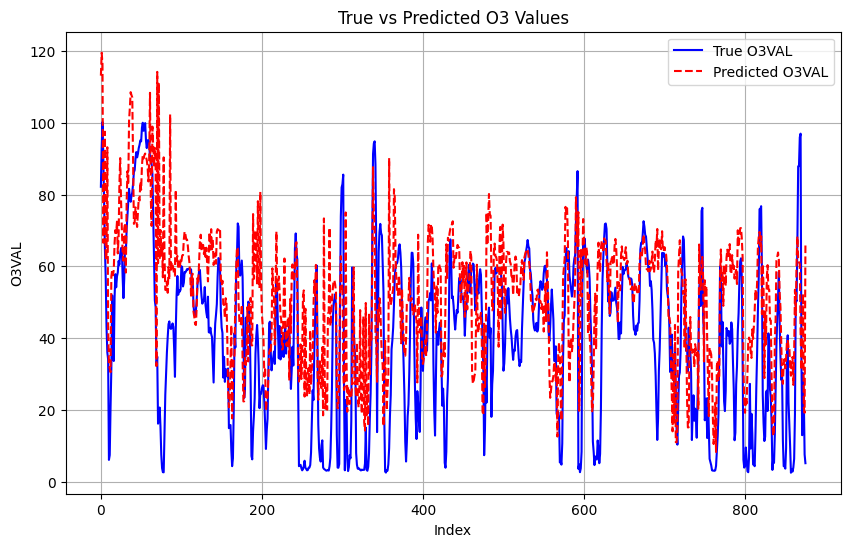

mean_absolute_error: 17.226821749917992
mean_squared_error: 481.0353614727004
rmse: 21.932518356830354
r2 score: 0.09671183392127625
corrcoef score: 0.6113316902115237


In [26]:
import math
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
# 预测测试集
predictions = model.predict(test_X_reshaped)

# 为了绘制曲线，我们需要将预测值从NumPy数组转换为列表，并考虑到我们可能需要对预测值进行反标准化（如果之前进行了标准化处理）
predicted_values = predictions.flatten().tolist()  # 假设我们需要展平并转换为list

# 同样，假设`test_y`是测试集的真实目标值，我们也需要它来绘制曲线
true_values = test_y.flatten().tolist()  # 假设test_y也是二维数组，需要展平处理

# 绘制真实值和预测值的曲线
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.plot(true_values, label='True O3VAL', color='blue')  # 使用真实值绘制曲线
plt.plot(predicted_values, label='Predicted O3VAL', color='red', linestyle='--')  # 使用预测值绘制曲线，设置为虚线以示区别
plt.xlabel('Index')  # x轴标签
plt.ylabel('O3VAL')  # y轴标签
plt.title('True vs Predicted O3 Values')  # 图形标题
plt.legend()  # 显示图例
plt.grid(True)  # 显示网格
plt.show()  # 显示图形

print("mean_absolute_error:", mean_absolute_error(true_values, predicted_values))
print("mean_squared_error:", mean_squared_error(true_values, predicted_values))
print("rmse:", math.sqrt(mean_squared_error(true_values, predicted_values)))
print("r2 score:", r2_score(true_values, predicted_values))
print("corrcoef score:", np.corrcoef(true_values, predicted_values)[0,1])